### Processing as Decorating II

In [1]:
import nographs as nog
from graphviz import Digraph

In [2]:
dict_1= {0:{1,2}, 1:{2,0}, 2:{0,1}, }

# dict_2= {0:{1,2,4}, 1:{3,5}, 2:{3,6}, 3:{37}, 37:{7}, 4:{5,6}, 5:{57}, 57:{7}, 
#          6:{67}, 67:{7}, 7:{} }

def forward(x, _):
    return dict_1[x]

In [3]:
# https://www.graphviz.org/doc/info/attrs.html
node_style =dict( style='filled', shape='box', 
                                align='left',
                                fontsize='12',
                                ranksep='0.01',
                                height='0.02',width='0.04',)
gr_style = dict( linelength="16",rankdir='LR')#landscape="True",layout="neato",splines='curved' 

def adapter_graphviz( to_deco ):
    dot = Digraph( node_attr = node_style, graph_attr = gr_style, )

    def wrapper_bg( x, t ):
        node = dot.node( str(hash(x)), str(x) )
        for result in to_deco(x, t):
            dot.edge( str(hash( x )), str(hash( result )), )
            yield result
    wrapper_bg.shared = getattr( to_deco,"shared",{})
    wrapper_bg.shared["dot"] = dot
    return wrapper_bg

In [4]:
class EdgeSplitter:
    def __init__(self, to_deco):
        self.to_deco = to_deco
        self.shared = getattr( to_deco,"shared",{}).copy()
        self.newbies = set()
        # update_wrapper(self, to_deco, updated=())
    def __call__(self, x, t):
        if x in self.newbies:
            yield x[1]
        else:
            for result in self.to_deco(x, t):
                # creating new vertex at the middle of edge, new id is tuple of edge's ends
                self.newbies.add((x, result))
                yield (x, result)

# test with reenterability
@adapter_graphviz
@EdgeSplitter
@EdgeSplitter
def double_splitted(x, _):
    return dict_1[x]

In [5]:
trav_forward = nog.TraversalBreadthFirst( double_splitted )
trav_forward.start_from( 0, build_paths=True )
str( list(trav_forward) )

'[(0, (0, 1)), (0, (0, 2)), (0, 1), (0, 2), ((0, 1), 1), ((0, 2), 2), 1, 2, (1, (1, 0)), (1, (1, 2)), (2, (2, 0)), (2, (2, 1)), (1, 0), (1, 2), (2, 0), (2, 1), ((1, 0), 0), ((1, 2), 2), ((2, 0), 0), ((2, 1), 1)]'

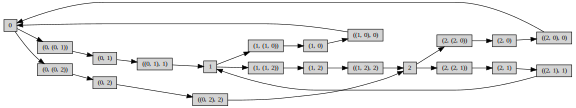

In [6]:
double_splitted.shared["dot"].attr(size='8,4')
# double_splitted.shared["dot"].attr( layout="neato")
double_splitted.shared["dot"]